<a href="https://colab.research.google.com/github/kdanny502/T2/blob/main/Mask_R_CNN_%EB%AC%BC%EC%B2%B4_%ED%81%AC%EA%B8%B0_%EC%B8%A1%EC%A0%95_%EB%B9%B5%ED%98%95%EC%9D%98_%EA%B0%9C%EB%B0%9C%EB%8F%84%EC%83%81%EA%B5%AD%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN

![](https://github.com/kairess/Mask_RCNN/raw/master/assets/4k_video.gif)

In [6]:
from IPython.display import HTML
HTML('<video src="https://user-images.githubusercontent.com/5242555/206883118-4bacf238-d265-4b9c-927a-26e5a2cc9083.webm" width="800" controls/>')

## TensorFlow 다운그레이드

2.9.2 -> 2.5.0

In [7]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [8]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
!dpkg -i libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
!ls -l /usr/lib/x86_64-linux-gnu/libcudnn.so.*
!pip install -U -qq tensorflow==2.5.0
exit() # 런타임 다시 시작 필요!

--2023-09-05 14:39:34--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 430460776 (411M) [application/x-deb]
Saving to: ‘libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb.2’

libcudnn8_8.1.0.77- 100%[===================>] 410.52M   298MB/s    in 1.4s    

2023-09-05 14:39:35 (298 MB/s) - ‘libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb.2’ saved [430460776/430460776]

(Reading database ... 120893 files and directories currently installed.)
Preparing to unpack libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+cuda11.2) over (8.1.0.77-1+cuda11.2) ...
Setting up libcudnn8 (8.1.0.77-1+cuda11.2) ...
lrwxrwxrwx 1 root root     17 Jan 25  2021 /usr/lib/x86_64-linux-gnu

# 새 섹션

# 새 섹션

In [1]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14949379977527073855
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 283999387226547480
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Tue Sep  5 14:30:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |    387MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataset 만들기

https://www.makesense.ai

In [ ]:
!pip install -U --no-cache-dir gdown --pre -qq

import gdown

gdown.download('https://drive.google.com/u/0/uc?id=1Cfj-1ylPstBObRqZJhJuGVLr1H1rjcio')

!unzip -qq mrcnn-dataset.zip

Downloading...
From: https://drive.google.com/u/0/uc?id=1Cfj-1ylPstBObRqZJhJuGVLr1H1rjcio
To: /content/mrcnn-dataset.zip
100%|██████████| 53.8M/53.8M [00:00<00:00, 175MB/s]


## Mask R-CNN 소스코드

- Modified for Colab: https://github.com/kairess/Mask_RCNN
- Modified: https://github.com/akTwelve/Mask_RCNN
- Original: https://github.com/matterport/Mask_RCNN

In [1]:
!git clone https://github.com/kairess/Mask_RCNN

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [2]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

ROOT_DIR = 'Mask_RCNN'

sys.path.append(ROOT_DIR)
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

## 사전학습 모델 다운로드

This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

It will also download the pre-trained coco model.

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


## Configuration

- NAME: weights, tensorboard 저장 폴더 이름
- IMAGES_PER_GPU: 배치 사이즈
- LEARNING_RATE
- NUM_CLASSES: 학습할 클래스 개수 (배경 +1 필요)

In [ ]:
class TrainConfig(Config):
    # Give the configuration a recognizable name
    NAME = "custom"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5

    LEARNING_RATE = 0.001

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 (red, green)

    # All of our training images are 1920x1012
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50' # resnet50

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Define the dataset

I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

In [ ]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()

        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids

## Create the Training and Validation Datasets
Make sure you download the training dataset linked at the top of this notebook. If you put the dataset somewhere else, update the paths below.

Train 20
Validation 5


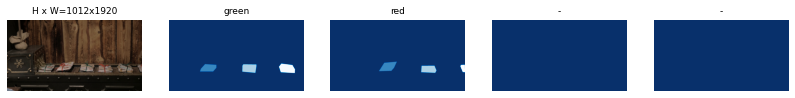

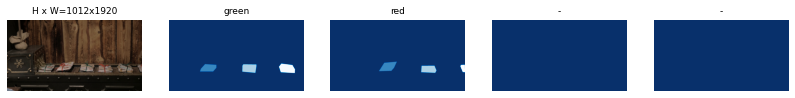

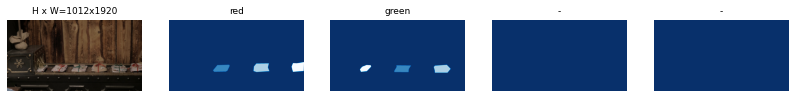

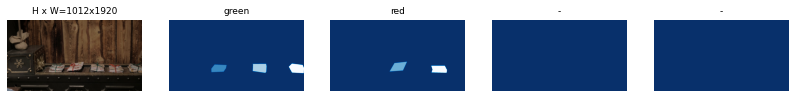

In [ ]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('dataset/train.json', 'dataset/train/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('dataset/val.json', 'dataset/val/')
dataset_val.prepare()

image_ids = np.random.choice(dataset_train.image_ids, 4)

print('Train', len(dataset_train.image_ids))
print('Validation', len(dataset_val.image_ids))

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create the Training Model
This code is largely borrowed from the train_shapes.ipynb notebook.

In [ ]:
model = modellib.MaskRCNN(
    mode="training",
    config=config,
    model_dir=MODEL_DIR)

model.load_weights(
    COCO_MODEL_PATH,
    by_name=True,
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.



### 1. Head Only

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()

model.train(
    dataset_train,
    dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=10,
    layers='heads')

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)

print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: Mask_RCNN/logs/custom20221211T0125/mask_rcnn_custom_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistr

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_5:0", shape=(Non

4/4 [==============================] - ETA: 0s - batch: 1.5000 - size: 5.0000 - loss: 3.5537 - rpn_class_loss: 0.1354 - rpn_bbox_loss: 0.6488 - mrcnn_class_loss: 1.0275 - mrcnn_bbox_loss: 1.0068 - mrcnn_mask_loss: 0.7352

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4/4 [==============================] - 45s 7s/step - batch: 1.5000 - size: 5.0000 - loss: 3.5537 - rpn_class_loss: 0.1354 - rpn_bbox_loss: 0.6488 - mrcnn_class_loss: 1.0275 - mrcnn_bbox_loss: 1.0068 - mrcnn_mask_loss: 0.7352 - val_loss: 2.5976 - val_rpn_class_loss: 0.0594 - val_rpn_bbox_loss: 0.4943 - val_mrcnn_class_loss: 0.6429 - val_mrcnn_bbox_loss: 0.8193 - val_mrcnn_mask_loss: 0.5818
Epoch 2/10
4/4 [==============================] - 9s 2s/step - batch: 1.5000 - size: 5.0000 - loss: 2.1184 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 0.3475 - mrcnn_class_loss: 0.5218 - mrcnn_bbox_loss: 0.6881 - mrcnn_mask_loss: 0.4937 - val_loss: 1.9808 - val_rpn_class_loss: 0.0717 - val_rpn_bbox_loss: 0.4567 - val_mrcnn_class_loss: 0.4180 - val_mrcnn_bbox_loss: 0.5954 - val_mrcnn_mask_loss: 0.4391
Epoch 3/10
4/4 [==============================] - 9s 2s/step - batch: 1.5000 - size: 5.0000 - loss: 1.6360 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 0.2843 - mrcnn_class_loss: 0.3660 - mrcnn_bbox_loss: 0.51

### 2. All layers

Optional

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()

model.train(
    dataset_train,
    dataset_val,
    learning_rate=config.LEARNING_RATE / 10,
    epochs=15,
    layers="all")

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)

print(f'Training took {minutes} minutes')


Starting at epoch 10. LR=0.0001

Checkpoint Path: Mask_RCNN/logs/custom20221211T0125/mask_rcnn_custom_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b       

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_5:0", 

4/4 [==============================] - ETA: 0s - batch: 1.5000 - size: 5.0000 - loss: 0.9185 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1598

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4/4 [==============================] - 27s 4s/step - batch: 1.5000 - size: 5.0000 - loss: 0.9185 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1598 - val_loss: 1.0820 - val_rpn_class_loss: 0.0113 - val_rpn_bbox_loss: 0.1660 - val_mrcnn_class_loss: 0.0751 - val_mrcnn_bbox_loss: 0.1091 - val_mrcnn_mask_loss: 0.1794
Epoch 12/15
4/4 [==============================] - 10s 3s/step - batch: 1.5000 - size: 5.0000 - loss: 0.9133 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1014 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1491 - val_loss: 1.0937 - val_rpn_class_loss: 0.0127 - val_rpn_bbox_loss: 0.1582 - val_mrcnn_class_loss: 0.1053 - val_mrcnn_bbox_loss: 0.1100 - val_mrcnn_mask_loss: 0.1606
Epoch 13/15
4/4 [==============================] - 9s 2s/step - batch: 1.5000 - size: 5.0000 - loss: 0.8339 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0

## Prepare to run Inference

Create a new InferenceConfig, then use it to create a new model.

In [ ]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.85

inference_config = InferenceConfig()

# Recreate the model in inference mode
test_model = modellib.MaskRCNN(
    mode="inference",
    config=inference_config,
    model_dir=MODEL_DIR)

model_path = test_model.find_last()
print(model_path)

test_model.load_weights(model_path, by_name=True)

Mask_RCNN/logs/custom20221211T0125/mask_rcnn_custom_0015.h5
Re-starting from epoch 15


## Run Inference

In [ ]:
import skimage

mask_colors = [
    (0., 0., 0.), # Background
    (1., 0., 0.), # Red
    (0., 1., 0.)  # Green
]

real_test_dir = 'dataset/val'
image_paths = []

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)

    results = test_model.detect([img_arr], verbose=1)
    r = results[0]

    colors = tuple(np.take(mask_colors, r['class_ids'], axis=0))

    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                dataset_val.class_names, r['scores'], figsize=(16, 8),
                                colors=colors)

## 높이 측정

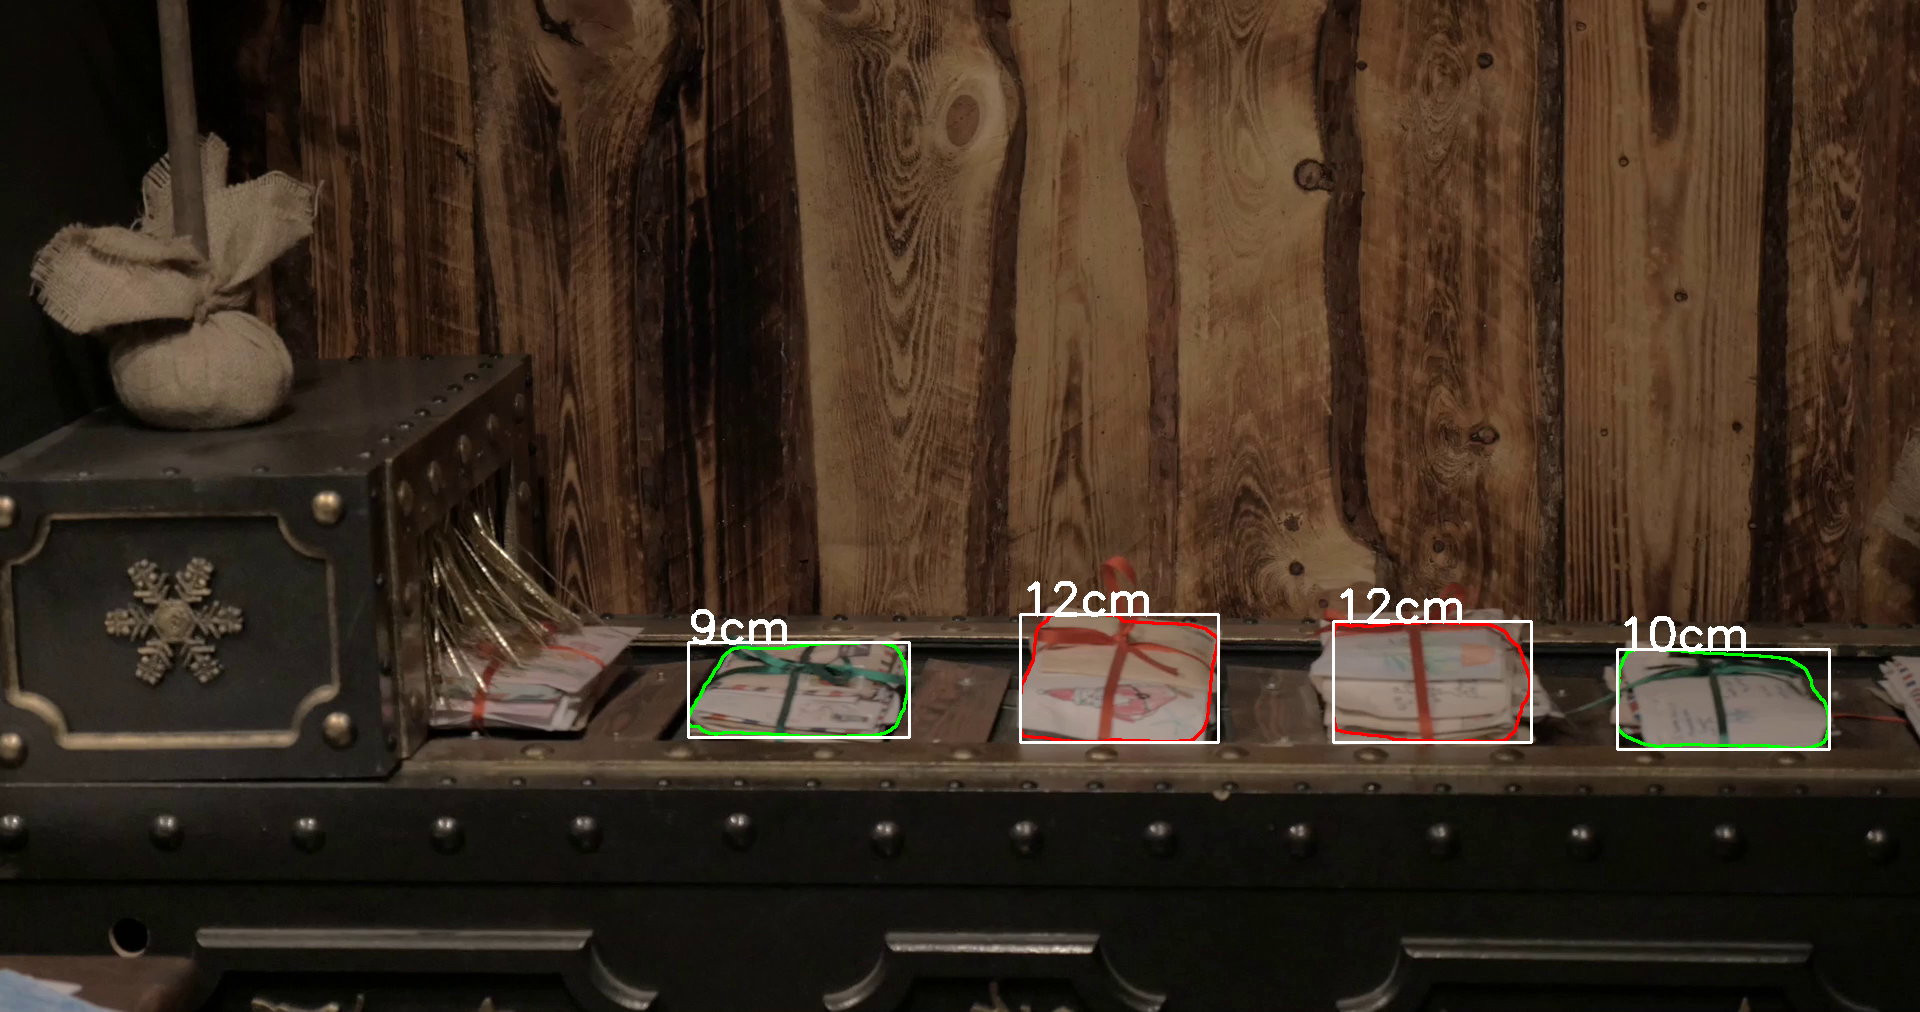

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

mask_colors_255 = [
    (0, 0, 0), # Background
    (0, 0, 255), # Red
    (0, 255, 0)  # Green
]

cap = cv2.VideoCapture('Mask_RCNN/assets/video.mov')

while cap.isOpened():
    ret, img = cap.read()

    results = test_model.detect([img])

    rois = results[0]['rois']
    class_ids = results[0]['class_ids']
    scores = results[0]['scores']
    masks = results[0]['masks']

    result_img = img.copy()

    for i, class_id in enumerate(class_ids):
        mask = masks[:, :, i].astype(np.float32)
        mask = (mask * 255).astype(np.uint8)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(result_img, contours, 0, mask_colors_255[class_id], 2)

        x, y, w, h = cv2.boundingRect(contours[0])
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (255, 255, 255), 2)

        # convert from pixel to mm
        ## 10 px = 1 cm
        ratio = 1 / 10
        cm = int(h * ratio)
        cv2.putText(result_img, f'{cm}cm', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)

    cv2_imshow(result_img)

    break

## 동영상 처리

In [ ]:
import cv2
from google.colab import files

mask_colors_255 = [
    (0, 0, 0), # Background
    (0, 0, 255), # Red
    (0, 255, 0)  # Green
]

cap = cv2.VideoCapture('Mask_RCNN/assets/video.mov')

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

while cap.isOpened():
    ret, img = cap.read()

    if not ret:
        break

    results = test_model.detect([img])

    rois = results[0]['rois']
    class_ids = results[0]['class_ids']
    scores = results[0]['scores']
    masks = results[0]['masks']

    result_img = img.copy()

    for i, class_id in enumerate(class_ids):
        mask = masks[:, :, i].astype(np.float32)
        mask = (mask * 255).astype(np.uint8)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(result_img, contours, 0, mask_colors_255[class_id], 2)

        x, y, w, h = cv2.boundingRect(contours[0])
        # cv2.rectangle(result_img, (x, y), (x + w, y + h), (255, 255, 255), 2)

        # convert from pixel to mm
        ## 10 px = 1 cm
        ratio = 1 / 10
        cm = int(h * ratio)
        cv2.putText(result_img, f'{cm}cm', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)

    out.write(result_img)

out.release()

files.download('output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>